# Volatility Model

In [1]:
from arch import arch_model
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller

In [2]:
# import data
df_train = pd.read_csv('../data/processed/SPY_Close_modeling_2.5y.csv')
df_train.tail()

,Date,close,log_return
618,2025-06-24,6092.18,0.011060
619,2025-06-25,6092.16,-0.000003
620,2025-06-26,6141.02,0.007988
621,2025-06-27,6173.07,0.005205
622,2025-06-30,6204.95,0.005151


In [3]:
df_test = pd.read_csv('../data/processed/SPY_Close_forecast_0.5y.csv')
df_test.head()

,Date,close,log_return
0,2025-07-01,6198.01,-0.001119
1,2025-07-02,6227.42,0.004734
2,2025-07-03,6279.35,0.008304
3,2025-07-07,6229.98,-0.007893
4,2025-07-08,6225.52,-0.000716


In [4]:
df_train = df_train.sort_values("Date").set_index("Date")
df_train.head()

,close,log_return
Date,,
2023-01-04,3852.97,0.007511
2023-01-05,3808.10,-0.011714
2023-01-06,3895.08,0.022584
2023-01-09,3892.09,-0.000768
2023-01-10,3919.25,0.006954


In [5]:
df_test = df_test.sort_values("Date").set_index("Date")
df_test.head()

,close,log_return
Date,,
2025-07-01,6198.01,-0.001119
2025-07-02,6227.42,0.004734
2025-07-03,6279.35,0.008304
2025-07-07,6229.98,-0.007893
2025-07-08,6225.52,-0.000716


In [15]:
df_train['log_return'].skew()

np.float64(0.386390035872416)

we can see in this time window, the skew is positive

### GARCH Modeling

In [6]:
# AR(0) mean model
y = df_train["log_return"].dropna()
mu = y.mean()
resid = y - mu

In [26]:
from arch import arch_model
import pandas as pd

# ------------------------------------------------------------
# Prepare residuals (already demeaned)
# ------------------------------------------------------------
resid_pct = 100 * resid

models = []

# ------------------------------------------------------------
# Define model configurations
# ------------------------------------------------------------
model_specs = [
    ("GARCH(1,1)-t", dict(vol="GARCH", p=1, q=1, dist="t")),
    ("EGARCH(1,1)-t", dict(vol="EGARCH", p=1, o=1, q=1, dist="t")),
    ("GJR(1,1)-t", dict(vol="GARCH", p=1, o=1, q=1, dist="t")),
    ("GARCH(1,1)-skewt", dict(vol="GARCH", p=1, q=1, dist="skewt")),
    ("EGARCH(1,1)-skewt", dict(vol="EGARCH", p=1, o=1, q=1, dist="skewt")),
    ("GJR(1,1)-skewt", dict(vol="GARCH", p=1, o=1, q=1, dist="skewt"))
]

# ------------------------------------------------------------
# Fit all models and collect information criteria
# ------------------------------------------------------------
for name, spec in model_specs:
    try:
        am = arch_model(
            resid_pct,
            mean="Zero",
            vol=spec["vol"],
            p=spec.get("p", 1),
            o=spec.get("o", 0),
            q=spec.get("q", 1),
            dist=spec["dist"]
        )
        
        fit = am.fit(disp="off")
        
        models.append({
            "Model": name,
            "AIC": fit.aic,
            "BIC": fit.bic,
            "LogLik": fit.loglikelihood
        })
        
    except:
        continue

# ------------------------------------------------------------
# Create comparison table
# ------------------------------------------------------------
comparison_df = pd.DataFrame(models).sort_values("BIC", ).reset_index(drop=True)

print("\n" + "="*60)
print("Model Comparison")
print("="*60)
print(comparison_df)



Model Comparison
               Model          AIC          BIC      LogLik
0  EGARCH(1,1)-skewt  1542.800551  1569.407830 -765.400275
1      EGARCH(1,1)-t  1550.033202  1572.205934 -770.016601
2     GJR(1,1)-skewt  1550.779384  1577.386663 -769.389692
3         GJR(1,1)-t  1557.797586  1579.970319 -773.898793
4       GARCH(1,1)-t  1586.664827  1604.403013 -789.332414
5   GARCH(1,1)-skewt  1582.644911  1604.817644 -786.322456


### Models Comparison

##### for skew-t distribution 
1. **eta:**  Controls tail thickness of the skewed Student’s t distribution, capturing the degree of fat-tail risk in returns.
2. **λ:** : Controls the skewness of the distribution, indicating whether extreme returns are more likely on the left (negative) or right (positive) side.

##### GARCH

In [19]:
garch11_skewt = arch_model(
    resid_pct,
    mean="Zero",
    vol="GARCH",
    p=1, q=1, 
    dist="skewt"
).fit(disp="off")

print(garch11_skewt.summary())

                             Zero Mean - GARCH Model Results                             
Dep. Variable:                        log_return   R-squared:                       0.000
Mean Model:                            Zero Mean   Adj. R-squared:                  0.002
Vol Model:                                 GARCH   Log-Likelihood:               -786.322
Distribution:      Standardized Skew Student's t   AIC:                           1582.64
Method:                       Maximum Likelihood   BIC:                           1604.82
                                                   No. Observations:                  623
Date:                           Sun, Feb 22 2026   Df Residuals:                      623
Time:                                   20:45:39   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
----------------------------------------

In [20]:
garch11_t = arch_model(
    resid_pct,
    mean="Zero",
    vol="GARCH",
    p=1, q=1, 
    dist="t"
).fit(disp="off")

print(garch11_t.summary())

                          Zero Mean - GARCH Model Results                           
Dep. Variable:                   log_return   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.002
Vol Model:                            GARCH   Log-Likelihood:               -789.332
Distribution:      Standardized Student's t   AIC:                           1586.66
Method:                  Maximum Likelihood   BIC:                           1604.40
                                              No. Observations:                  623
Date:                      Sun, Feb 22 2026   Df Residuals:                      623
Time:                              20:45:57   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega     

**The GARCH(1,1) with Skewed Student's t distribution is the superior model** 

- **Optimal Information Criteria:** TThe Skewed Student's t model achieves a lower AIC (1582.64) compared to the standard t-distribution (1586.66), indicating a more precise fit to the empirical data.

- **Significant Asymmetry::** The skewness parameter (lambda) is statistically significant (p = 0.011), confirming that SPY returns exhibit non-symmetric behavior that a standard t-distribution fails to capture.

- **Reliable Persistence Estimates:** All core volatility parameters (alpha and beta) remain highly significant (p < 0.01), ensuring stable estimates of volatility clustering.

##### GJR-GARCH

In [22]:
gjr_garch11_skewt = arch_model(
    resid_pct,
    mean="Zero",
    vol="GARCH",
    p=1, o=1, q=1,
    dist="skewt"
).fit(disp="off")

print(gjr_garch11_skewt.summary())

                           Zero Mean - GJR-GARCH Model Results                           
Dep. Variable:                        log_return   R-squared:                       0.000
Mean Model:                            Zero Mean   Adj. R-squared:                  0.002
Vol Model:                             GJR-GARCH   Log-Likelihood:               -769.390
Distribution:      Standardized Skew Student's t   AIC:                           1550.78
Method:                       Maximum Likelihood   BIC:                           1577.39
                                                   No. Observations:                  623
Date:                           Sun, Feb 22 2026   Df Residuals:                      623
Time:                                   20:48:40   Df Model:                            0
                            Volatility Model                            
                 coef    std err          t      P>|t|  95.0% Conf. Int.
--------------------------------------------

In [23]:
gjr_garch11_t = arch_model(
    resid_pct,
    mean="Zero",
    vol="GARCH",
    p=1, o=1, q=1,
    dist="t"
).fit(disp="off")

print(gjr_garch11_t.summary())

                        Zero Mean - GJR-GARCH Model Results                         
Dep. Variable:                   log_return   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.002
Vol Model:                        GJR-GARCH   Log-Likelihood:               -773.899
Distribution:      Standardized Student's t   AIC:                           1557.80
Method:                  Maximum Likelihood   BIC:                           1579.97
                                              No. Observations:                  623
Date:                      Sun, Feb 22 2026   Df Residuals:                      623
Time:                              20:50:41   Df Model:                            0
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega  

**The GJR-GARCH with Skewed Student's t distribution is the superior model** 

- **Optimal Information Criteria:** This model yields the lowest AIC (1550.78) across all tested configurations, indicating the best balance between model complexity and data fit.

- **Superior Log-Likelihood:** It achieves the highest Log-Likelihood (-769.39), demonstrating that the Skewed Student's t distribution maps the empirical S&P 500 returns more accurately than the standard t-distribution.

##### EGARCH

In [27]:
egarch11_t = arch_model(
    resid_pct,
    mean="Zero",
    vol="EGARCH",
    p=1, o=1, q=1,
    dist="t"
).fit(disp="off")

print(egarch11_t.summary())

                          Zero Mean - EGARCH Model Results                          
Dep. Variable:                   log_return   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.002
Vol Model:                           EGARCH   Log-Likelihood:               -770.017
Distribution:      Standardized Student's t   AIC:                           1550.03
Method:                  Maximum Likelihood   BIC:                           1572.21
                                              No. Observations:                  623
Date:                      Sun, Feb 22 2026   Df Residuals:                      623
Time:                              21:24:27   Df Model:                            0
                               Volatility Model                               
                 coef    std err          t      P>|t|        95.0% Conf. Int.
-----------------------------------------------------------------------------

In [25]:
egarch11_skewt = arch_model(
    resid_pct,
    mean="Zero",
    vol="EGARCH",
    p=1,o=1, q=1,
    dist="skewt"
).fit(disp="off")

print(egarch11_skewt.summary())

                             Zero Mean - EGARCH Model Results                            
Dep. Variable:                        log_return   R-squared:                       0.000
Mean Model:                            Zero Mean   Adj. R-squared:                  0.002
Vol Model:                                EGARCH   Log-Likelihood:               -765.400
Distribution:      Standardized Skew Student's t   AIC:                           1542.80
Method:                       Maximum Likelihood   BIC:                           1569.41
                                                   No. Observations:                  623
Date:                           Sun, Feb 22 2026   Df Residuals:                      623
Time:                                   21:23:09   Df Model:                            0
                               Volatility Model                               
                 coef    std err          t      P>|t|        95.0% Conf. Int.
--------------------------------

**The EGARCH(1,1) with Skewed Student's t distribution is the superior model** 

- **Statistical Evidence of Skewness:** All key parameters—including the leverage effect (gamma) and the skewness parameter (lambda)—are highly significant (p < 0.01), ensuring the model is not over-fitted.

- **Superior Fit Metrics:** This model achieves a lower **AIC to 1542.90** (compared to 1550.03 for the standard t), proving that accounting for skewness provides a more precise representation of the data.

- **Capturing Distributional Bias:** The significant lambda (-0.1691) confirms that the residuals are negatively skewed, a crucial detail for risk management that the standard t-distribution misses.

#### Conclusion: 
- Overall GARCH-Models with skew-t distribution performanced better than t-distribution. for later prediction and residual test, we will only use GARCH-Models with skew-t distribution

In [29]:
from statsmodels.stats.diagnostic import het_arch

# ------------------------------------------------------------
# ARCH-LM for GARCH(1,1)-skewt
# ------------------------------------------------------------
std_garch = garch11_skewt.std_resid.dropna()
lm_stat, lm_pvalue, f_stat, f_pvalue = het_arch(std_garch, nlags=10)

print("\n" + "="*60)
print("ARCH-LM Test: GARCH(1,1)-skewt")
print("="*60)
print(f"Lags Used     : 10")
print(f"LM Statistic  : {lm_stat:.4f}")
print(f"LM p-value    : {lm_pvalue:.6f}")
print(f"F Statistic   : {f_stat:.4f}")
print(f"F p-value     : {f_pvalue:.6f}")


# ------------------------------------------------------------
# ARCH-LM for GJR(1,1)-skewt
# ------------------------------------------------------------
std_gjr = gjr_garch11_skewt.std_resid.dropna() 
lm_stat, lm_pvalue, f_stat, f_pvalue = het_arch(std_gjr, nlags=10)

print("\n" + "="*60)
print("ARCH-LM Test: GJR(1,1)-skewt")
print("="*60)
print(f"Lags Used     : 10")
print(f"LM Statistic  : {lm_stat:.4f}")
print(f"LM p-value    : {lm_pvalue:.6f}")
print(f"F Statistic   : {f_stat:.4f}")
print(f"F p-value     : {f_pvalue:.6f}")


# ------------------------------------------------------------
# ARCH-LM for EGARCH(1,1)-skewt
# ------------------------------------------------------------
std_egarch = egarch11_skewt.std_resid.dropna() 
lm_stat, lm_pvalue, f_stat, f_pvalue = het_arch(std_egarch, nlags=10)

print("\n" + "="*60)
print("ARCH-LM Test: EGARCH(1,1)-skewt")
print("="*60)
print(f"Lags Used     : 10")
print(f"LM Statistic  : {lm_stat:.4f}")
print(f"LM p-value    : {lm_pvalue:.6f}")
print(f"F Statistic   : {f_stat:.4f}")
print(f"F p-value     : {f_pvalue:.6f}")



ARCH-LM Test: GARCH(1,1)-skewt
Lags Used     : 10
LM Statistic  : 26.2256
LM p-value    : 0.003448
F Statistic   : 2.6906
F p-value     : 0.003127

ARCH-LM Test: GJR(1,1)-skewt
Lags Used     : 10
LM Statistic  : 8.5353
LM p-value    : 0.576698
F Statistic   : 0.8500
F p-value     : 0.580412

ARCH-LM Test: EGARCH(1,1)-skewt
Lags Used     : 10
LM Statistic  : 11.9468
LM p-value    : 0.288634
F Statistic   : 1.1966
F p-value     : 0.289992


**ARCH-LM Test Interpretation** 

The ARCH-LM test checks whether remaining ARCH effects still exist in model residuals.
- Null hypothesis (H₀): No ARCH effects remain (model is adequate)
- If p-value < 0.05 → ARCH effects remain → model is inadequate
- If p-value > 0.05 → no ARCH effects → model captures volatility well

Result: 
1. GARCH(1,1) – Skew-t: 
    - LM p-value: 0.0034 -> Reject H₀ → ARCH effects remain
2. GJR-GARCH(1,1) – Skew-t: 
    - LM p-value: 0.5767 -> Fail to reject H₀ → no remaining ARCH effects
3. EGARCH(1,1) – Skew-t: 
    - LM p-value: 0.2886 -> Fail to reject H₀ → no remaining ARCH effects

In [30]:
# Ljung-Box test on squared standardized residuals
from statsmodels.stats.diagnostic import acorr_ljungbox

# --- Diagnostics for GARCH(1,1)-skewt ---
lb_garch_sq = acorr_ljungbox(std_garch**2, lags=[10, 20], return_df=True)

print("\n" + "="*60)
print("GARCH(1,1)-skewt: Ljung-Box on squared standardized residuals")
print("="*60)
print(lb_garch_sq)

# --- Diagnostics for GJR(1,1)-skewt ---  
lb_gjr_sq = acorr_ljungbox(std_gjr**2, lags=[10, 20], return_df=True)

print("\n" + "="*60)
print("GJR(1,1)-skewt: Ljung-Box on squared standardized residuals")
print("="*60)
print(lb_gjr_sq)

# --- Diagnostics for EGARCH(1,1)-skewt ---  
lb_egarch_sq = acorr_ljungbox(std_egarch**2, lags=[10, 20], return_df=True)

print("\n" + "="*60)
print("EGARCH(1,1)-skewt: Ljung-Box on squared standardized residuals")
print("="*60)
print(lb_egarch_sq)


GARCH(1,1)-skewt: Ljung-Box on squared standardized residuals
      lb_stat  lb_pvalue
10  27.885004   0.001883
20  31.987317   0.043434

GJR(1,1)-skewt: Ljung-Box on squared standardized residuals
      lb_stat  lb_pvalue
10   9.536517   0.482052
20  14.537845   0.802214

EGARCH(1,1)-skewt: Ljung-Box on squared standardized residuals
      lb_stat  lb_pvalue
10  13.045715   0.221127
20  16.324374   0.696308


**Ljung–Box Test on Squared Standardized Residuals**

This test checks whether remaining autocorrelation in volatility exists after model estimation.
- H₀: No autocorrelation remains (model captures volatility dynamics)
- p-value < 0.05 → remaining structure exists → model inadequate
- p-value > 0.05 → no remaining structure → model adequate

Result: 
1. GARCH(1,1) – Skew-t: 
    - Lag 10 p-value: 0.0019 -> Reject H₀ → significant autocorrelation remains
    - Lag 20 p-value: 0.0434 -> Reject H₀ → significant autocorrelation remains
2. GJR-GARCH(1,1) – Skew-t: 
    - Lag 10 p-value: 0.4821 -> Fail to reject H₀ → no remaining autocorrelation
    - Lag 20 p-value: 0.8022 -> Fail to reject H₀ → no remaining autocorrelation
3. EGARCH(1,1) – Skew-t: 
    - Lag 10 p-value: 0.2211 -> Fail to reject H₀ → no remaining autocorrelation
    - Lag 20 p-value: 0.6963 -> Fail to reject H₀ → no remaining autocorrelation

In [31]:
# get returns for train and test sets
train_ret = df_train["log_return"].dropna()
test_ret  = df_test["log_return"].dropna()

train_ret.head()
test_ret.head()

Date
2025-07-01   -0.001119
2025-07-02    0.004734
2025-07-03    0.008304
2025-07-07   -0.007893
2025-07-08   -0.000716
Name: log_return, dtype: float64

From Ljung-Box test, GJR-GARCH(1,1)'s p-value > 0.05, does not reject H0(there is no significant autocorrelation in residual), which mean residual is white noice, we successfully capture the trend 

### EWMA Modeling

In [32]:
# resid: demeaned returns (AR(0) residuals)
lambda_ = 0.94

train_returns_pct = 100 * train_ret
test_returns_pct = 100 * test_ret

# Initial variance from training sample
sigma2 = np.var(train_returns_pct)

ewma_forecasts = []

for r in test_returns_pct:
    
    # Update variance using previous observation
    sigma2 = lambda_ * sigma2 + (1 - lambda_) * r**2
    
    ewma_forecasts.append(sigma2)

ewma_forecasts = np.array(ewma_forecasts)

In [33]:
realized_variance = test_returns_pct.values**2

# MSE
ewma_mse = np.mean((ewma_forecasts - realized_variance)**2)

# QLIKE
ewma_qlike = np.mean(
    np.log(ewma_forecasts) +
    realized_variance / ewma_forecasts
)

print("EWMA MSE:", ewma_mse)
print("EWMA QLIKE:", ewma_qlike)

EWMA MSE: 0.7311456421972939
EWMA QLIKE: 0.12937239674206413


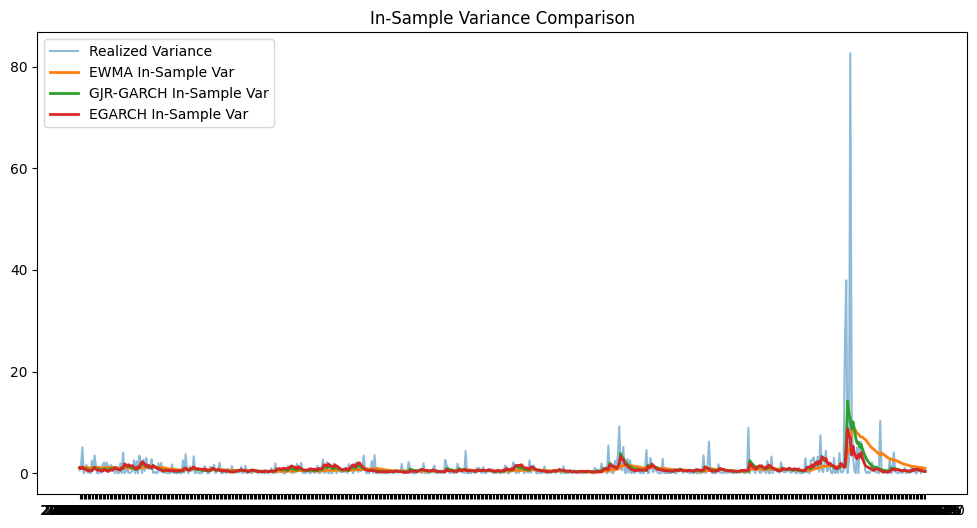

In [35]:
#   in-sample variance comparison
gjr_in_sample_variance = gjr_garch11_skewt.conditional_volatility**2
egarch_in_sample_variance = egarch11_skewt.conditional_volatility**2
realized_variance = train_returns_pct.values**2

lambda_ = 0.94
returns = train_returns_pct.values
ewma_var_in = np.zeros(len(returns))
ewma_var_in[0] = np.var(returns)

for t in range(1, len(returns)):
    ewma_var_in[t] = (
        lambda_ * ewma_var_in[t-1] +
        (1 - lambda_) * returns[t-1]**2
    )

plt.figure(figsize=(12, 6))

plt.plot(realized_variance, label="Realized Variance", alpha=0.5)
plt.plot(ewma_var_in, label="EWMA In-Sample Var", linewidth=2)
plt.plot(gjr_in_sample_variance, label="GJR-GARCH In-Sample Var", linewidth=2)
plt.plot(egarch_in_sample_variance, label="EGARCH In-Sample Var", linewidth=2)

plt.title("In-Sample Variance Comparison")
plt.legend()
plt.show()

### Volatility Model Forecasting

In [36]:
# Scale returns (recommended for stability)
train_returns_pct = 100 * train_ret
test_returns_pct  = 100 * test_ret

# Store forecasts
rolling_var_forecasts = []

In [49]:
# ------------------------------------------------------------
# Step 2: Expanding-window rolling 1-step-ahead forecasts
# ------------------------------------------------------------

# Store forecasts separately
rolling_var_gjr = []
rolling_var_egarch = []

for i in range(len(test_returns_pct)):

    # Expanding window data
    rolling_data = np.concatenate([
        train_returns_pct.values,
        test_returns_pct.values[:i]
    ])

    # -------------------------------
    # GJR-GARCH(1,1) - Skew-t
    # -------------------------------
    model_gjr = arch_model(
        rolling_data,
        mean="Zero",
        vol="GARCH",
        p=1, o=1, q=1,
        dist="skewt"
    )

    fit_gjr = model_gjr.fit(disp="off")
    f_gjr = fit_gjr.forecast(horizon=1, reindex=False)

    rolling_var_gjr.append(f_gjr.variance.values[-1, 0])

    # -------------------------------
    # EGARCH(1,1) - Skew-t
    # -------------------------------
    model_egarch = arch_model(
        rolling_data,
        mean="Zero",
        vol="EGARCH",
        p=1, o=1, q=1,
        dist="skewt"
    )

    fit_egarch = model_egarch.fit(disp="off")
    f_egarch = fit_egarch.forecast(horizon=1, reindex=False)

    rolling_var_egarch.append(f_egarch.variance.values[-1, 0])


# Convert to numpy arrays
rolling_var_gjr = np.array(rolling_var_gjr)
rolling_var_egarch = np.array(rolling_var_egarch)

print("GJR Rolling length:", len(rolling_var_gjr))
print("EGARCH Rolling length:", len(rolling_var_egarch))

GJR Rolling length: 128
EGARCH Rolling length: 128


In [ ]:
realized_var_test = test_returns_pct.values**2

ewma_var = ewma_forecasts
gjr_var = rolling_var_gjr
egarch_var = rolling_var_egarch

print(len(realized_var_test),
      len(ewma_var),
      len(gjr_var),
      len(egarch_var))

128 128 128 128


In [54]:
# -------------------------
# EWMA
# -------------------------
mse_ewma  = np.mean((realized_var_test - ewma_var)**2)
mae_ewma  = np.mean(np.abs(realized_var_test - ewma_var))
rmse_ewma = np.sqrt(mse_ewma)
qlike_ewma = np.mean(
    np.log(ewma_var) + realized_var_test / ewma_var
)

# -------------------------
# GJR
# -------------------------
mse_gjr  = np.mean((realized_var_test - gjr_var)**2)
mae_gjr  = np.mean(np.abs(realized_var_test - gjr_var))
rmse_gjr = np.sqrt(mse_gjr)
qlike_gjr = np.mean(
    np.log(gjr_var) + realized_var_test / gjr_var
)

# -------------------------
# EGARCH
# -------------------------
mse_egarch  = np.mean((realized_var_test - egarch_var)**2)
mae_egarch  = np.mean(np.abs(realized_var_test - egarch_var))
rmse_egarch = np.sqrt(mse_egarch)
qlike_egarch = np.mean(
    np.log(egarch_var) + realized_var / egarch_var
)

In [55]:
print("====== Forecast Evaluation (Out-of-Sample) ======")

print("\n--- EWMA ---")
print("MSE   :", mse_ewma)
print("RMSE  :", rmse_ewma)
print("MAE   :", mae_ewma)
print("QLIKE :", qlike_ewma)

print("\n--- GJR-GARCH ---")
print("MSE   :", mse_gjr)
print("RMSE  :", rmse_gjr)
print("MAE   :", mae_gjr)
print("QLIKE :", qlike_gjr)

print("\n--- EGARCH ---")
print("MSE   :", mse_egarch)
print("RMSE  :", rmse_egarch)
print("MAE   :", mae_egarch)
print("QLIKE :", qlike_egarch)

====== Forecast Evaluation (Out-of-Sample) ======

--- EWMA ---
MSE   : 0.7311456421972939
RMSE  : 0.8550705480820247
MAE   : 0.502081882157441
QLIKE : 0.12937239674206413

--- GJR-GARCH ---
MSE   : 0.8296922740885185
RMSE  : 0.910874455722916
MAE   : 0.552665458865008
QLIKE : 0.25188829198156537

--- EGARCH ---
MSE   : 0.7809069550365841
RMSE  : 0.8836893996402718
MAE   : 0.5532448379985192
QLIKE : 0.2196434003501824


## Conclusion: 
- EWMA outperforms GARCH-type models in out-of-sample volatility forecasting.
- Simpler models can outperform complex ones when market volatility shifts quickly.
- GARCH-family models may fit in-sample dynamics better but can overfit.

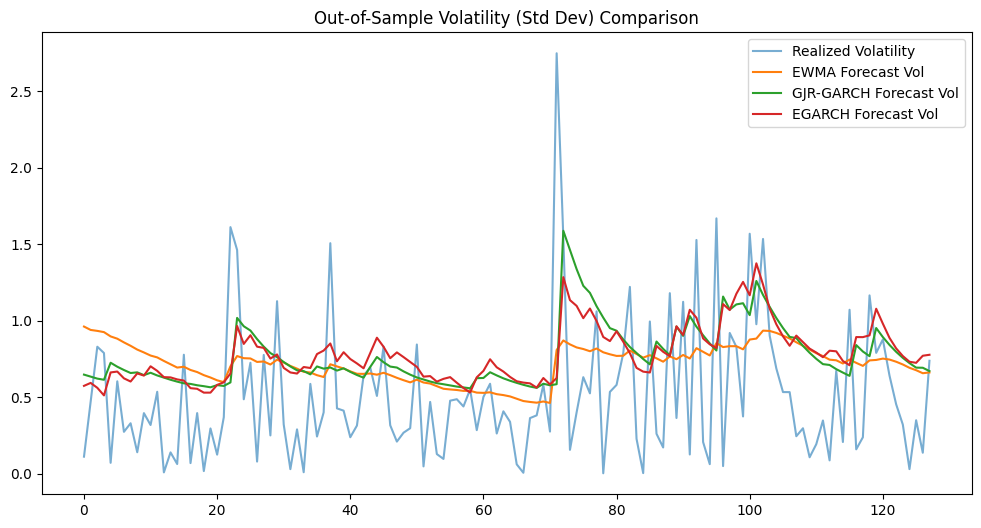

In [50]:
realized_var_test = test_returns_pct.values**2
plt.figure(figsize=(12,6))

plt.plot(np.sqrt(realized_var_test), label="Realized Volatility", alpha=0.6)
plt.plot(np.sqrt(ewma_forecasts), label="EWMA Forecast Vol")
plt.plot(np.sqrt(rolling_var_gjr), label="GJR-GARCH Forecast Vol")
plt.plot(np.sqrt(rolling_var_egarch), label="EGARCH Forecast Vol")

plt.title("Out-of-Sample Volatility (Std Dev) Comparison")
plt.legend()
plt.show()